In [146]:
import matplotlib
matplotlib.use('Agg')

import collections
import numpy as np
import os
import h5py
from scipy.stats import zscore
import pyret.filtertools as ft
import pyret.spiketools as sp
import pyret.stimulustools as st
from deepretina.toolbox import load_model, load_partial_model, rolling_window
from deepretina.io import despine
from deepretina.metrics import cc
from scipy.interpolate import interp1d
from scipy.signal import detrend

from tqdm import tqdm

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

plt.style.use('deepretina')

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'seismic'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
data_dir = os.path.expanduser('~/data/kastner/')
horizontals = [x[0] for x in os.walk(data_dir + 'horizontal')]
amacrines = [x[0] for x in os.walk(data_dir + 'amacrine')]
bipolars = [x[0] for x in os.walk(data_dir + 'bipolar') if 'reproduce' not in x[0]]

### Take shortest amount of data so you can store all interneurons as an array with the same time

In [35]:
boxes_len = None
intraRF_v_len = None
lines_len = None
for idh,h_file in enumerate(horizontals):
    try:
        boxes = np.loadtxt(h_file + '/' + 'boxes.txt', skiprows=1)
        boxes = boxes.reshape((-1, 38, 38))
        if (not boxes_len) or (boxes.shape[0] < boxes_len):
            boxes_len = boxes.shape[0]
            print('%s has boxes shape %d' %(h_file.split('/')[-1], boxes_len))
            
        intraRF_v = np.loadtxt(h_file + '/' + 'intraRF_v.txt', skiprows=1)
        if (not intraRF_v_len) or (len(intraRF_v) < intraRF_v_len):
            intraRF_v_len = len(intraRF_v)
            print('%s has intraRF_v shape %d' %(h_file.split('/')[-1], intraRF_v_len))
    
        lines = np.loadtxt(h_file + '/' + 'lines.txt', skiprows=1)
        lines = lines.reshape((-1, 100))
        if (not lines_len) or (lines.shape[0] < lines_len):
            lines_len = lines.shape[0]
            print('%s has lines shape %d' %(h_file.split('/')[-1], lines_len))

    except:
        print(h_file)

/Users/lmcintosh/data/kastner/horizontal
011812_c1 has boxes shape 18000
011812_c1 has intraRF_v shape 200000
011812_c1 has lines shape 8998
090312_r1_c1 has boxes shape 16659
090312_r1_c1 has intraRF_v shape 100000


In [19]:
boxes_len

16659

In [20]:
intraRF_v_len

100000

In [21]:
lines_len

8998

In [23]:
h_file

'/Users/lmcintosh/data/kastner/horizontal/122412_r2_c1'

In [ ]:
boxes_time = np.linspace(0, 500.015, boxes_len)
lines_time = np.linspace(0, )

In [34]:
len(lines)

9996

300.027*(8998/9996)

1/18/12 was linesRF(300, 35, 4, 0) #ft 0.033361 s
12/24/12 was linesRF(200, 35, 5, 0) #ft 0.0100049 s

In [36]:
h_file

'/Users/lmcintosh/data/kastner/horizontal/122412_r2_c1'

In [39]:
with open(h_file + '/' + 'README.txt', 'r') as f:
    text = f.read()

In [41]:
lines = text.split('\n')

In [45]:
times = collections.defaultdict(list)
for l in lines:
    params = l.split(', ')
    for p in params[1:]:
        times[params[0]].append(float(p))

In [46]:
times

defaultdict(list,
            {'boxes': [0.0, 500.015],
             'flash': [0.0005, 2.0005],
             'flashStim': [0.0, 22.0],
             'flash_v': [0.0, 22.0],
             'intraRF': [0.0, 0.5],
             'intraRF_v': [0.0005, 100.001],
             'lines': [0.0, 300.027],
             'linesRF': [0.0, 0.5, 0.0, 2.2],
             'linesRF_v': [0.0005, 200.0]})

In [50]:
time_intraRF_v = np.linspace(times['intraRF_v'][0], times['intraRF_v'][1], len(intraRF_v))

In [52]:
np.mean(np.diff(time_intraRF_v))

0.0010000150001500015

In [53]:
time_boxes = np.linspace(times['boxes'][0], times['boxes'][1], boxes.shape[0])

In [54]:
np.mean(np.diff(time_boxes))

0.030016508584463919

In [57]:
minimum_times = {}
all_times = collections.defaultdict(list)
for idh,h_file in enumerate(horizontals):
    try:
        with open(h_file + '/' + 'README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['boxes', 'flash', 'flashStim', 'flash_v',
                                 'intraRF', 'intraRF_v', 'lines', 'linesRF_v']:
                    all_times[params[0]].append(float(params[-1]))

    except:
        print(h_file)
        
for key in all_times.keys():
    minimum_times[key] = np.min(all_times[key])

In [58]:
minimum_times

{'boxes': 500.01499999999999,
 'flash': 2.0005000000000002,
 'flashStim': 22.0,
 'flash_v': 22.0,
 'intraRF': 0.5,
 'intraRF_v': 100.001,
 'lines': 300.02699999999999,
 'linesRF_v': 180.0}

# Some interneuron membrane potentials are sampled at 33 Hz, others at 100 Hz. Let's upsample everything to be 100 Hz.

In [78]:
sampling_rate = 0.01
target_times = collections.defaultdict(list)
for key in minimum_times.keys():
    target_times[key] = np.linspace(0, minimum_times[key], int(minimum_times[key]/sampling_rate))

receptive_fields = {
    'intraRF': collections.defaultdict(list),
    'linesRF': collections.defaultdict(list),
    'flash': collections.defaultdict(list)
    }

membrane_potentials = {
    'intraRF_v': collections.defaultdict(list),
    'linesRF_v': collections.defaultdict(list),
    'flash_v': collections.defaultdict(list)
}

detrended_membrane_potentials = {
    'intraRF_v': collections.defaultdict(list),
    'linesRF_v': collections.defaultdict(list),
    'flash_v': collections.defaultdict(list)
}
smoothing_filter = np.ones((int(2/.001),)) # 2 second smoothing filter

for idh,h_file in tqdm(enumerate(horizontals)):
    if h_file != '/Users/lmcintosh/data/kastner/horizontal':
        h_id = h_file.split('/')[-1]
        
        # stimuli
#         boxes = np.loadtxt(h_file + '/boxes.txt', skiprows=1)
#         lines = np.loadtxt(h_file + '/lines.txt', skiprows=1)
#         flashStim = np.loadtxt(h_file + '/flashStim.txt', skiprows=1)
        
        # receptive fields
        intraRF = np.loadtxt(h_file + '/intraRF.txt', skiprows=1)
        linesRF = np.loadtxt(h_file + '/linesRF.txt', skiprows=1)
        flash = np.loadtxt(h_file + '/flash.txt', skiprows=1)
        
        # membrane potential
        intraRF_v = np.loadtxt(h_file + '/intraRF_v.txt', skiprows=1)
        linesRF_v = np.loadtxt(h_file + '/linesRF_v.txt', skiprows=1)
        flash_v = np.loadtxt(h_file + '/flash_v.txt', skiprows=1)
        
        # reshape relevant variables
#         boxes = boxes.reshape((-1, 38, 38))
#         lines = lines.reshape((-1, 100))
        intraRF = intraRF.reshape((-1, 38, 38))
        linesRF = linesRF.reshape((-1, 100))
        
        # save RFs
        receptive_fields['intraRF'][h_id] = intraRF
        receptive_fields['linesRF'][h_id] = linesRF
        receptive_fields['flash'][h_id] = flash
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['flash', 'flash_v', 'intraRF', 'intraRF_v', 'linesRF_v']:
                    times[params[0]] = np.linspace(float(params[1]), float(params[2]), len(eval(params[0])))
        
        # interpolate membrane potentials
        for key in ['flash_v', 'intraRF_v', 'linesRF_v']:
            mem_pot_interp = interp1d(times[key], eval(key), kind='linear', bounds_error=False,
                                     fill_value='extrapolate')
            membrane_potentials[key][h_id] = mem_pot_interp(target_times[key])
            
            # detrend
            detrended_mem_pot = np.convolve(smoothing_filter/smoothing_filter.sum(), eval(key), mode='same')
            detrended_interp = interp1d(times[key], detrended_mem_pot, kind='linear', bounds_error=False,
                                       fill_value='extrapolate')
            detrended_membrane_potentials[key][h_id] = detrended_interp(target_times[key])


/Users/lmcintosh/Library/Python/3.5/lib/python/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [79]:
for expt in receptive_fields['linesRF']:
    print(receptive_fields['linesRF'][expt].shape)

(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)
(50, 100)


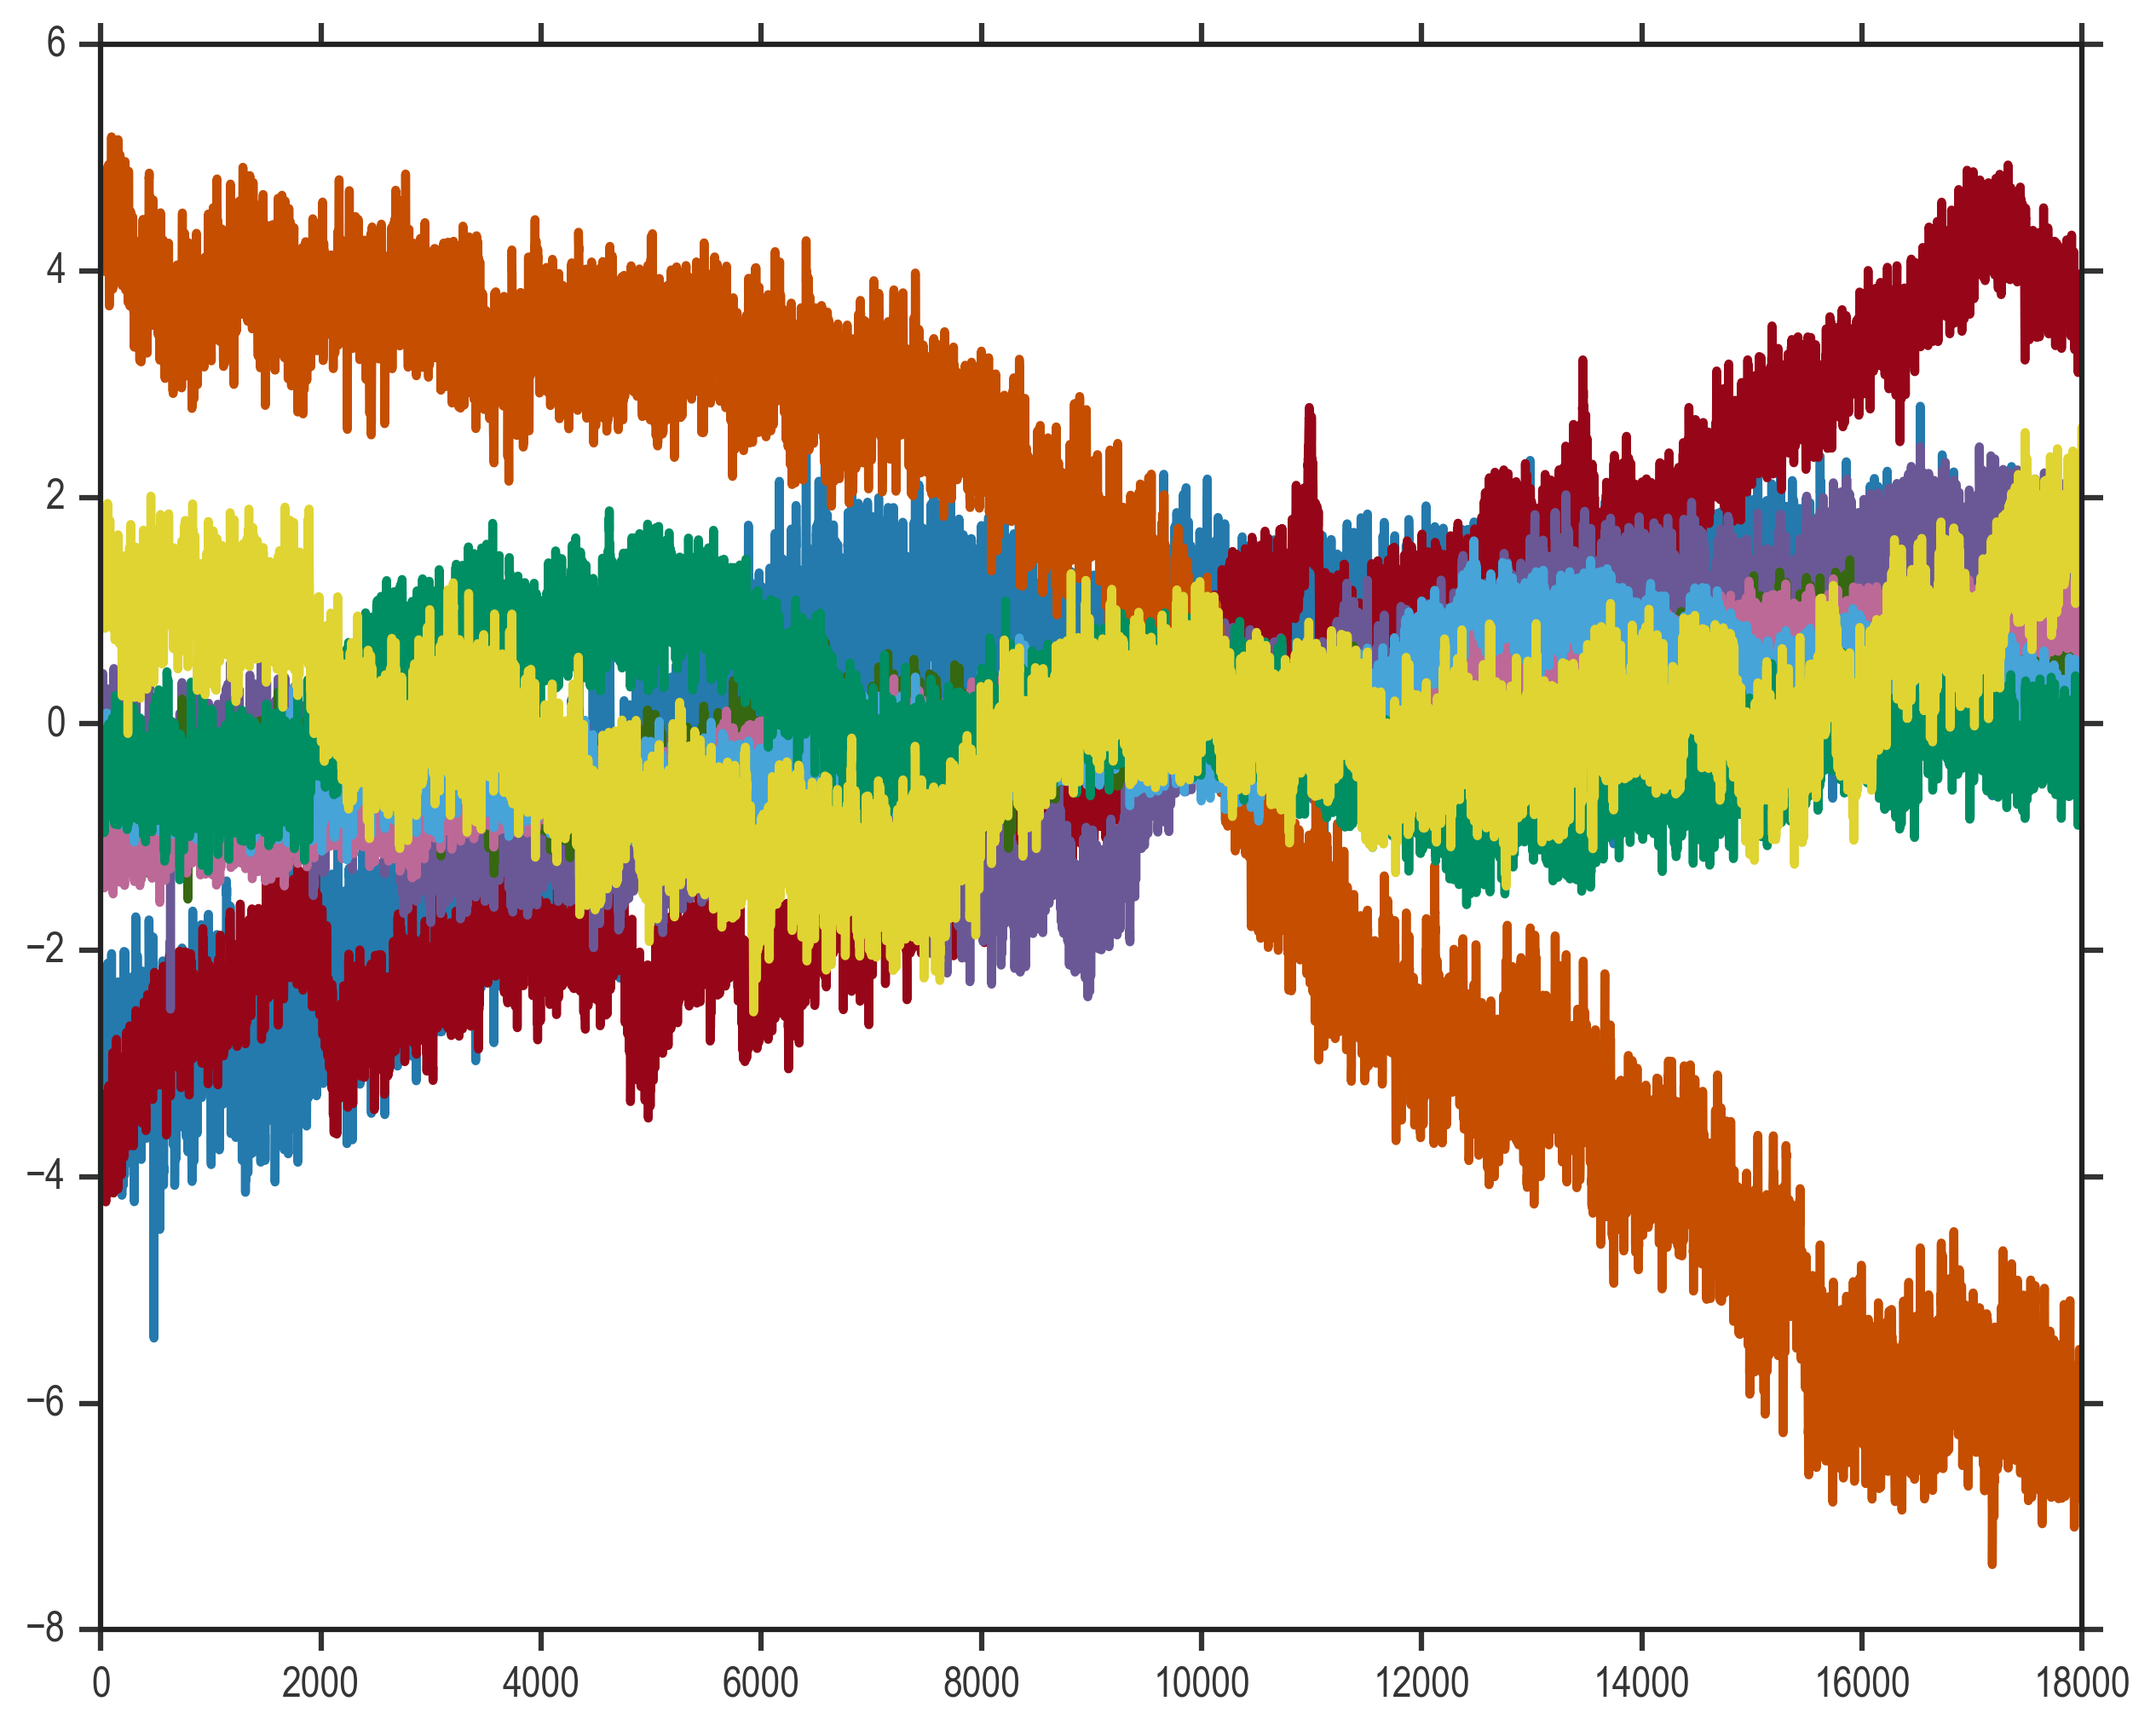

In [80]:
for expt in membrane_potentials['linesRF_v']:
    plt.plot(membrane_potentials['linesRF_v'][expt] - np.mean(membrane_potentials['linesRF_v'][expt]))
# xlim(200,220)

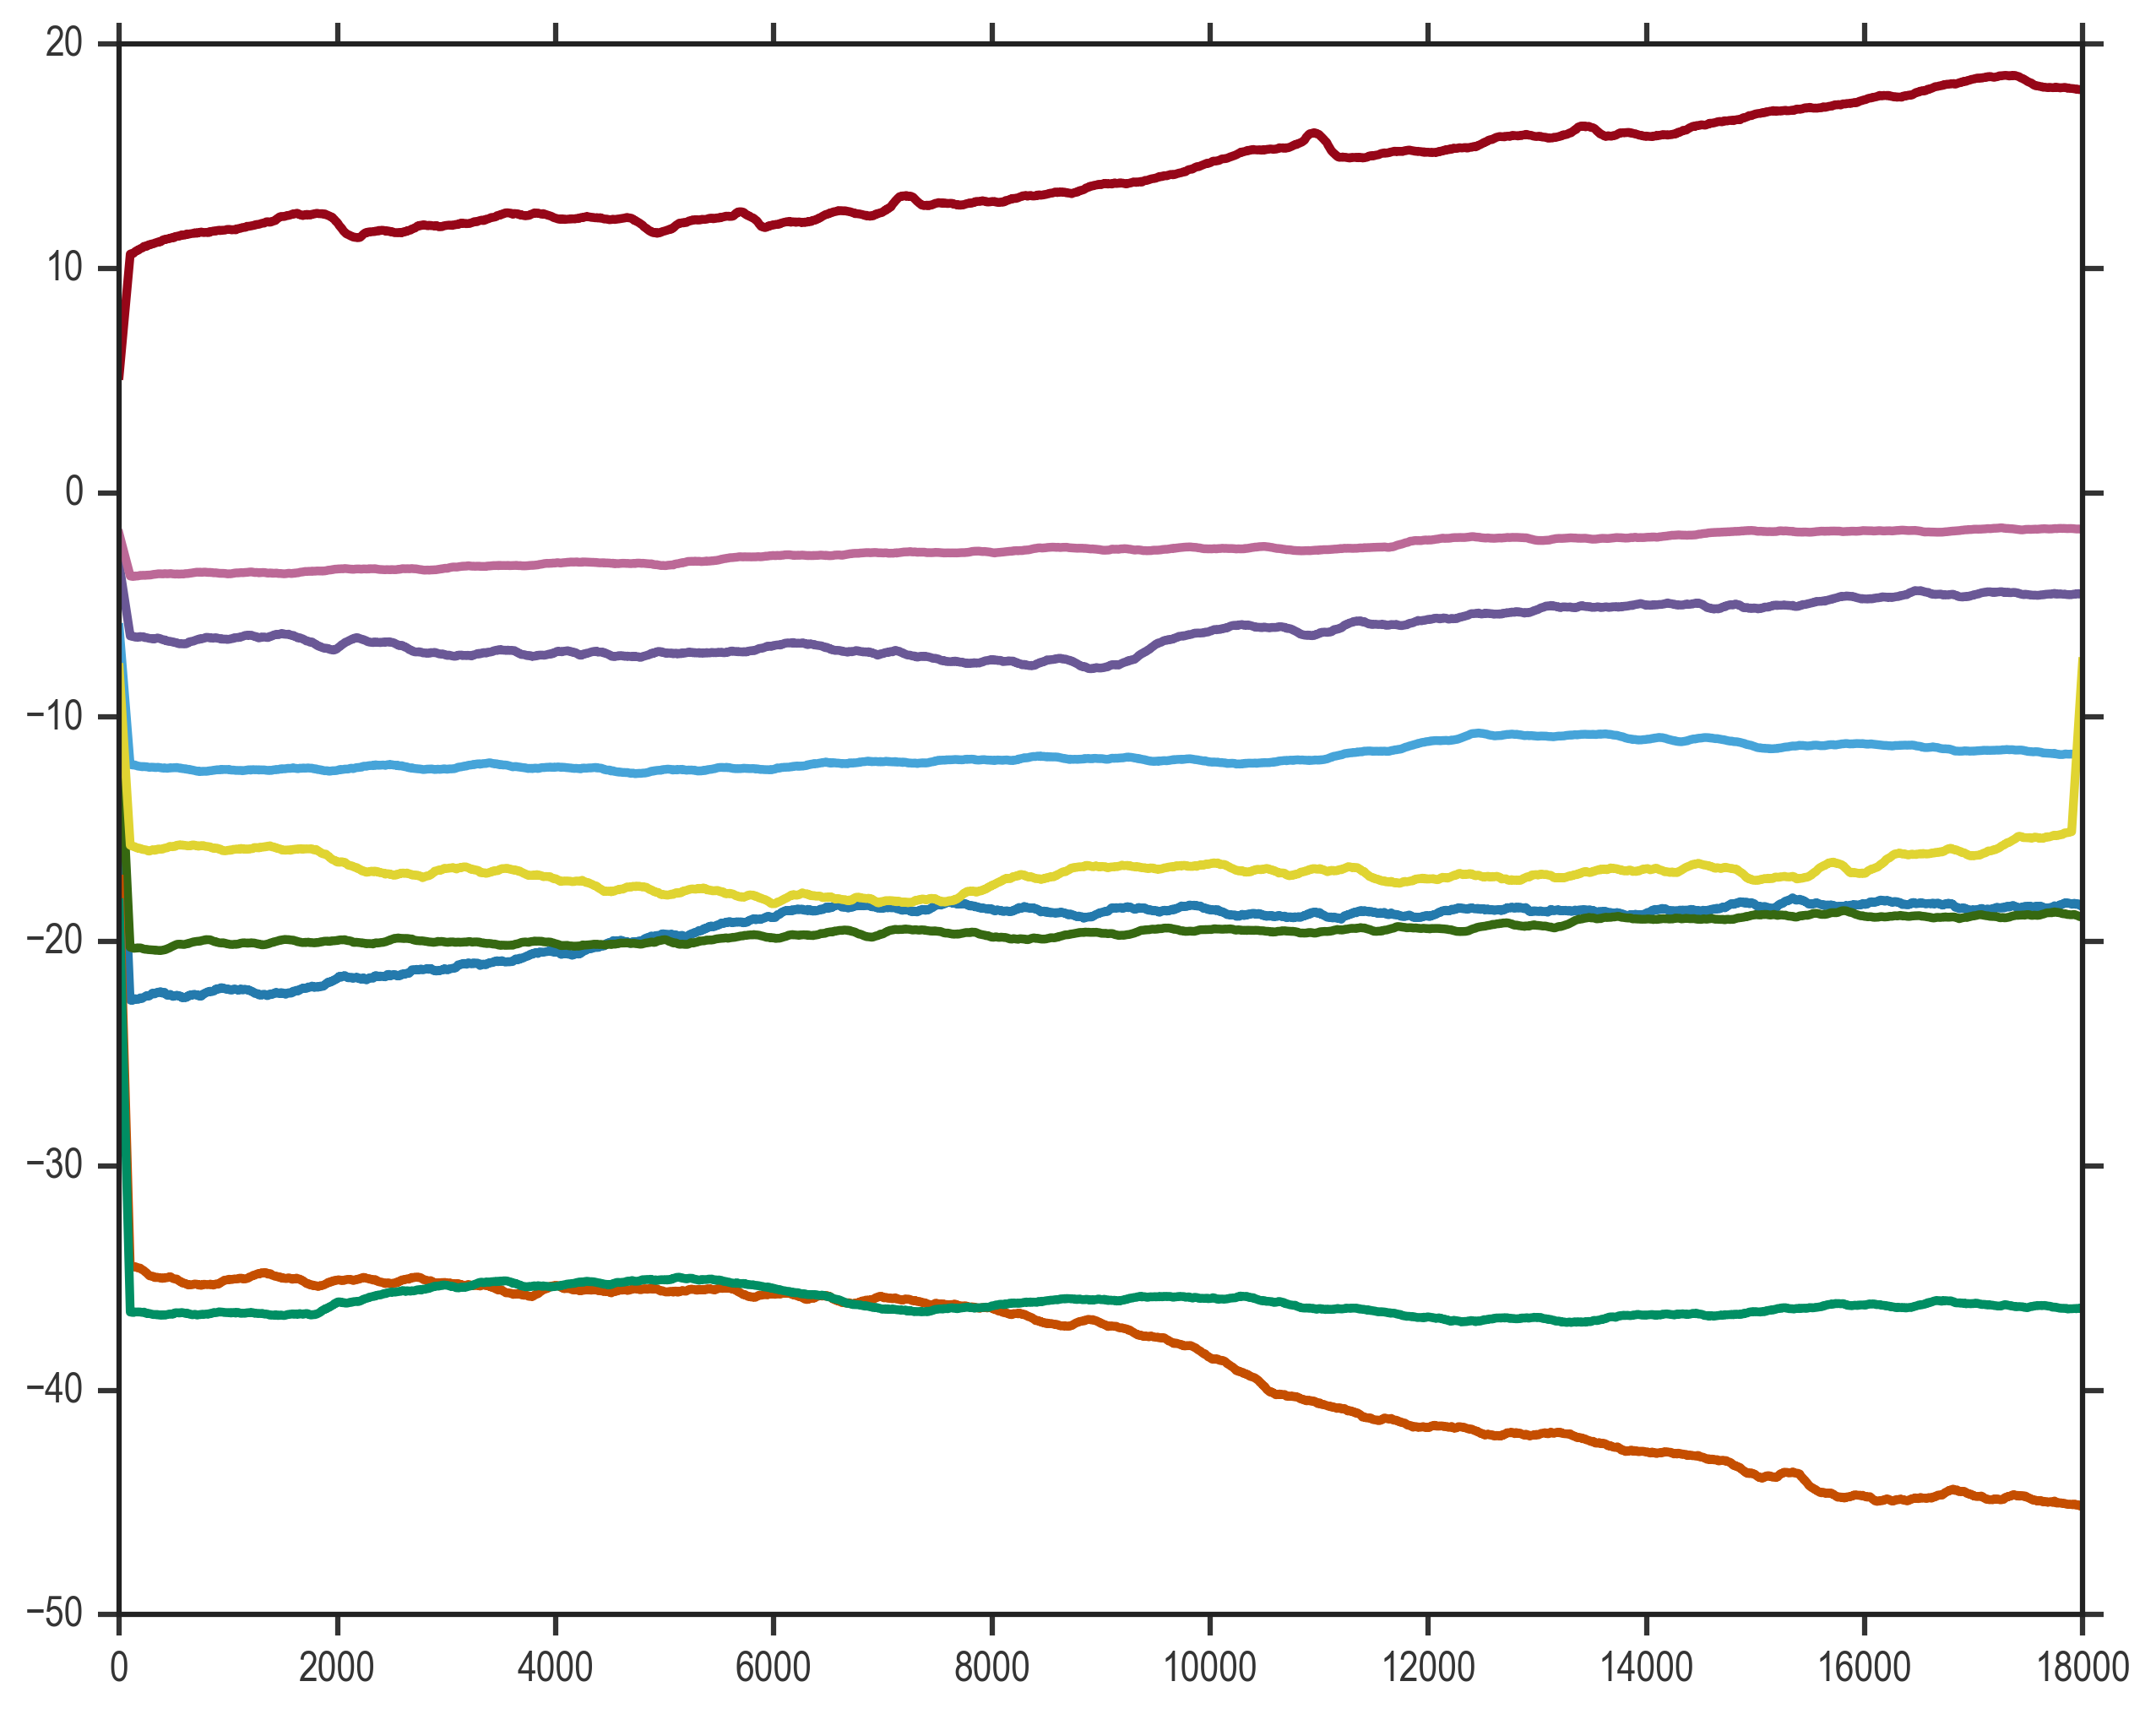

In [81]:
for expt in detrended_membrane_potentials['linesRF_v']:
    plt.plot(detrended_membrane_potentials['linesRF_v'][expt])
# xlim(200,220)

# Now worry about interpolating/truncating the stimuli

In [105]:
stimulus_times = {
    'boxes': collections.defaultdict(list),
    'flashStim': collections.defaultdict(list),
    'lines': collections.defaultdict(list)
    }
truncated_stim_times = {
    'boxes': collections.defaultdict(list),
    'flashStim': collections.defaultdict(list),
    'lines': collections.defaultdict(list)
    }

for idh,h_file in tqdm(enumerate(horizontals)):
    if h_file != '/Users/lmcintosh/data/kastner/horizontal':
        h_id = h_file.split('/')[-1]
        
        # stimuli
        boxes = np.loadtxt(h_file + '/boxes.txt', skiprows=1)
        lines = np.loadtxt(h_file + '/lines.txt', skiprows=1)
        flashStim = np.loadtxt(h_file + '/flashStim.txt', skiprows=1)
        
        # reshape stimuli
        boxes = boxes.reshape((-1, 38, 38))
        lines = lines.reshape((-1, 100))
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            readme_lines = text.split('\n')
            for l in readme_lines:
                params = l.split(', ')
                if params[0] in ['flashStim', 'boxes', 'lines']:
                    times[params[0]] = np.linspace(float(params[-2]), float(params[-1]), len(eval(params[0])))
                    scaling_factor = np.mean(np.diff(times[params[0]]))/sampling_rate
                    if scaling_factor > 1:
                        print('%s in %s is going to be upsampled by %f' %(params[0], h_id, scaling_factor))
                        stim_us, time_us = st.upsample_stim(eval(params[0]), int(scaling_factor), times[params[0]])
                    else:
                        print('%s in %s is going to be downsampled by %f' %(params[0], h_id, 1./scaling_factor))
                        stim_us, time_us = st.downsample_stim(eval(params[0]), int(1./scaling_factor), times[params[0]])

                    stimulus_times[params[0]][h_id].append(time_us)
                    if params[0] in ['flashStim']:
                        idx = np.argmin(abs(minimum_times['flash_v'] - time_us))
                        truncated_stim_times['flashStim'][h_id].append(time_us[:idx])
                    elif params[0] in ['boxes']:
                        idx = np.argmin(abs(minimum_times['intraRF_v'] - time_us))
                        truncated_stim_times['boxes'][h_id].append(time_us[:idx])
                    elif params[0] in ['lines']:
                        idx = np.argmin(abs(minimum_times['linesRF_v'] - time_us))
                        truncated_stim_times['lines'][h_id].append(time_us[:idx])

0it [00:00, ?it/s]

boxes in 011812_c1 is going to be upsampled by 3.334796
lines in 011812_c1 is going to be upsampled by 3.334978

2it [00:37, 18.63s/it]


flashStim in 011812_c1 is going to be downsampled by 99.999545
boxes in 020612_c2 is going to be upsampled by 3.334796
lines in 020612_c2 is going to be upsampled by 3.334978
flashStim in 020612_c2 is going to be downsampled by 99.999545

3it [01:13, 23.83s/it]


boxes in 090312_r1_c1 is going to be upsampled by 3.001651
lines in 090312_r1_c1 is going to be upsampled by 3.001771

4it [01:49, 27.47s/it]


flashStim in 090312_r1_c1 is going to be downsampled by 99.999545
boxes in 092312_r1_c1 is going to be upsampled by 3.001651
lines in 092312_r1_c1 is going to be upsampled by 3.001771

5it [02:23, 29.45s/it]


flashStim in 092312_r1_c1 is going to be downsampled by 99.999545
boxes in 092312_r3_c1 is going to be upsampled by 3.001651
lines in 092312_r3_c1 is going to be upsampled by 3.001771

6it [02:58, 31.04s/it]


flashStim in 092312_r3_c1 is going to be downsampled by 99.999545
boxes in 120212_r1_c1 is going to be upsampled by 3.001651
lines in 120212_r1_c1 is going to be upsampled by 3.001771

7it [03:33, 32.34s/it]


flashStim in 120212_r1_c1 is going to be downsampled by 99.999545
boxes in 121612_r2_c1 is going to be upsampled by 3.001651
lines in 121612_r2_c1 is going to be upsampled by 3.001771

8it [04:08, 33.25s/it]


flashStim in 121612_r2_c1 is going to be downsampled by 99.999545
boxes in 122412_r1_c1 is going to be upsampled by 3.001651
lines in 122412_r1_c1 is going to be upsampled by 3.001771
flashStim in 122412_r1_c1 is going to be downsampled by 99.999545

9it [04:43, 33.58s/it]


boxes in 122412_r2_c1 is going to be upsampled by 3.001651
lines in 122412_r2_c1 is going to be upsampled by 3.001771


flashStim in 122412_r2_c1 is going to be downsampled by 99.999545


In [ ]:
# for expt in truncated_stim_times['boxes'].keys():
#     plt.plot(truncated_stim_times['boxes'][expt])

In [114]:
for expt in truncated_stim_times['boxes'].keys():
    print(truncated_stim_times['boxes'][expt][0][-1], len(truncated_stim_times['boxes'][expt][0]), expt)

99.9949955977 9995 121612_r2_c1
99.9883113877 8996 011812_c1
99.9949955977 9995 120212_r1_c1
99.9949955977 9995 092312_r1_c1
99.9949955977 9995 090312_r1_c1
99.9949955977 9995 092312_r3_c1
99.9949955977 9995 122412_r2_c1
99.9883113877 8996 020612_c2
99.9949955977 9995 122412_r1_c1


## Since David made all the stimuli the same, just save one of them

In [120]:
expt = '122412_r2_c1'
stimuli = {}
stimuli_time = {}

for idh,h_file in enumerate(horizontals):
    h_id = h_file.split('/')[-1]
    if h_id == expt:
        # stimuli
        boxes = np.loadtxt(h_file + '/boxes.txt', skiprows=1)
        lines = np.loadtxt(h_file + '/lines.txt', skiprows=1)
        flashStim = np.loadtxt(h_file + '/flashStim.txt', skiprows=1)
        
        # reshape stimuli
        boxes = boxes.reshape((-1, 38, 38))
        lines = lines.reshape((-1, 100))
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            readme_lines = text.split('\n')
            for l in readme_lines:
                params = l.split(', ')
                if params[0] in ['flashStim', 'boxes', 'lines']:
                    times[params[0]] = np.linspace(float(params[-2]), float(params[-1]), len(eval(params[0])))
                    scaling_factor = np.mean(np.diff(times[params[0]]))/sampling_rate
                    if scaling_factor > 1:
                        print('%s in %s is going to be upsampled by %f' %(params[0], h_id, scaling_factor))
                        stim_us, time_us = st.upsample_stim(eval(params[0]), int(scaling_factor), times[params[0]])
                    else:
                        print('%s in %s is going to be downsampled by %f' %(params[0], h_id, 1./scaling_factor))
                        stim_us, time_us = st.downsample_stim(eval(params[0]), int(1./scaling_factor), times[params[0]])

                    if params[0] in ['flashStim']:
                        idx = np.argmin(abs(minimum_times['flash_v'] - time_us))
                        stimuli_time['flashStim'] = time_us[:idx]
                        stimuli['flashStim'] = stim_us[:idx]
                    elif params[0] in ['boxes']:
                        idx = np.argmin(abs(minimum_times['intraRF_v'] - time_us))
                        stimuli_time['boxes'] = time_us[:idx]
                        stimuli['boxes'] = stim_us[:idx]
                    elif params[0] in ['lines']:
                        idx = np.argmin(abs(minimum_times['linesRF_v'] - time_us))
                        stimuli_time['lines'] = time_us[:idx]
                        stimuli['lines'] = stim_us[:idx]

boxes in 122412_r2_c1 is going to be upsampled by 3.001651
lines in 122412_r2_c1 is going to be upsampled by 3.001771
flashStim in 122412_r2_c1 is going to be downsampled by 99.999545


In [121]:
stimuli['boxes'].shape

(9995, 38, 38)

In [126]:
stimuli_time['boxes'].shape

(9995,)

In [122]:
stimuli['lines'].shape

(17989, 100)

In [125]:
stimuli_time['lines'].shape

(17989,)

In [123]:
stimuli['flashStim'].shape

(2222,)

In [124]:
stimuli_time['flashStim'].shape

(2222,)

# Go back and re-save all membrane potentials but with new target time

In [137]:
sampling_rate = 0.01
target_times = {}
for key in minimum_times.keys():
    if key == 'intraRF_v':
        target_times[key] = stimuli_time['boxes']
    elif key == 'linesRF_v':
        target_times[key] = stimuli_time['lines']
    elif key == 'flash_v':
        target_times[key] = stimuli_time['flashStim']
        
receptive_fields = {
    'intraRF': collections.defaultdict(list),
    'linesRF': collections.defaultdict(list),
    'flash': collections.defaultdict(list)
    }

membrane_potentials = {
    'intraRF_v': collections.defaultdict(list),
    'linesRF_v': collections.defaultdict(list),
    'flash_v': collections.defaultdict(list)
}

detrended_membrane_potentials = {
    'intraRF_v': collections.defaultdict(list),
    'linesRF_v': collections.defaultdict(list),
    'flash_v': collections.defaultdict(list)
}
smoothing_step = int(2/.001) # 2 second smoothing filter

for idh,h_file in tqdm(enumerate(horizontals)):
    if h_file != '/Users/lmcintosh/data/kastner/horizontal':
        h_id = h_file.split('/')[-1]
        
        # receptive fields
        intraRF = np.loadtxt(h_file + '/intraRF.txt', skiprows=1)
        linesRF = np.loadtxt(h_file + '/linesRF.txt', skiprows=1)
        flash = np.loadtxt(h_file + '/flash.txt', skiprows=1)
        
        # membrane potential
        intraRF_v = np.loadtxt(h_file + '/intraRF_v.txt', skiprows=1)
        linesRF_v = np.loadtxt(h_file + '/linesRF_v.txt', skiprows=1)
        flash_v = np.loadtxt(h_file + '/flash_v.txt', skiprows=1)
        
        # reshape relevant variables
        intraRF = intraRF.reshape((-1, 38, 38))
        linesRF = linesRF.reshape((-1, 100))
        
        # save RFs
        receptive_fields['intraRF'][h_id] = intraRF
        receptive_fields['linesRF'][h_id] = linesRF
        receptive_fields['flash'][h_id] = flash
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['flash', 'flash_v', 'intraRF', 'intraRF_v', 'linesRF_v']:
                    times[params[0]] = np.linspace(float(params[1]), float(params[2]), len(eval(params[0])))
        
        # interpolate membrane potentials
        for key in ['flash_v', 'intraRF_v', 'linesRF_v']:
            mem_pot_interp = interp1d(times[key], eval(key), kind='linear', bounds_error=False,
                                     fill_value='extrapolate')
            membrane_potentials[key][h_id] = mem_pot_interp(target_times[key])
            
            # detrend
            detrended_mem_pot = detrend(eval(key), type='linear', bp=np.arange(smoothing_step, 
                                                                               len(eval(key))-smoothing_step,
                                                                               smoothing_step))
            
            detrended_interp = interp1d(times[key], detrended_mem_pot, kind='linear', bounds_error=False,
                                       fill_value='extrapolate')
            detrended_membrane_potentials[key][h_id] = detrended_interp(target_times[key])


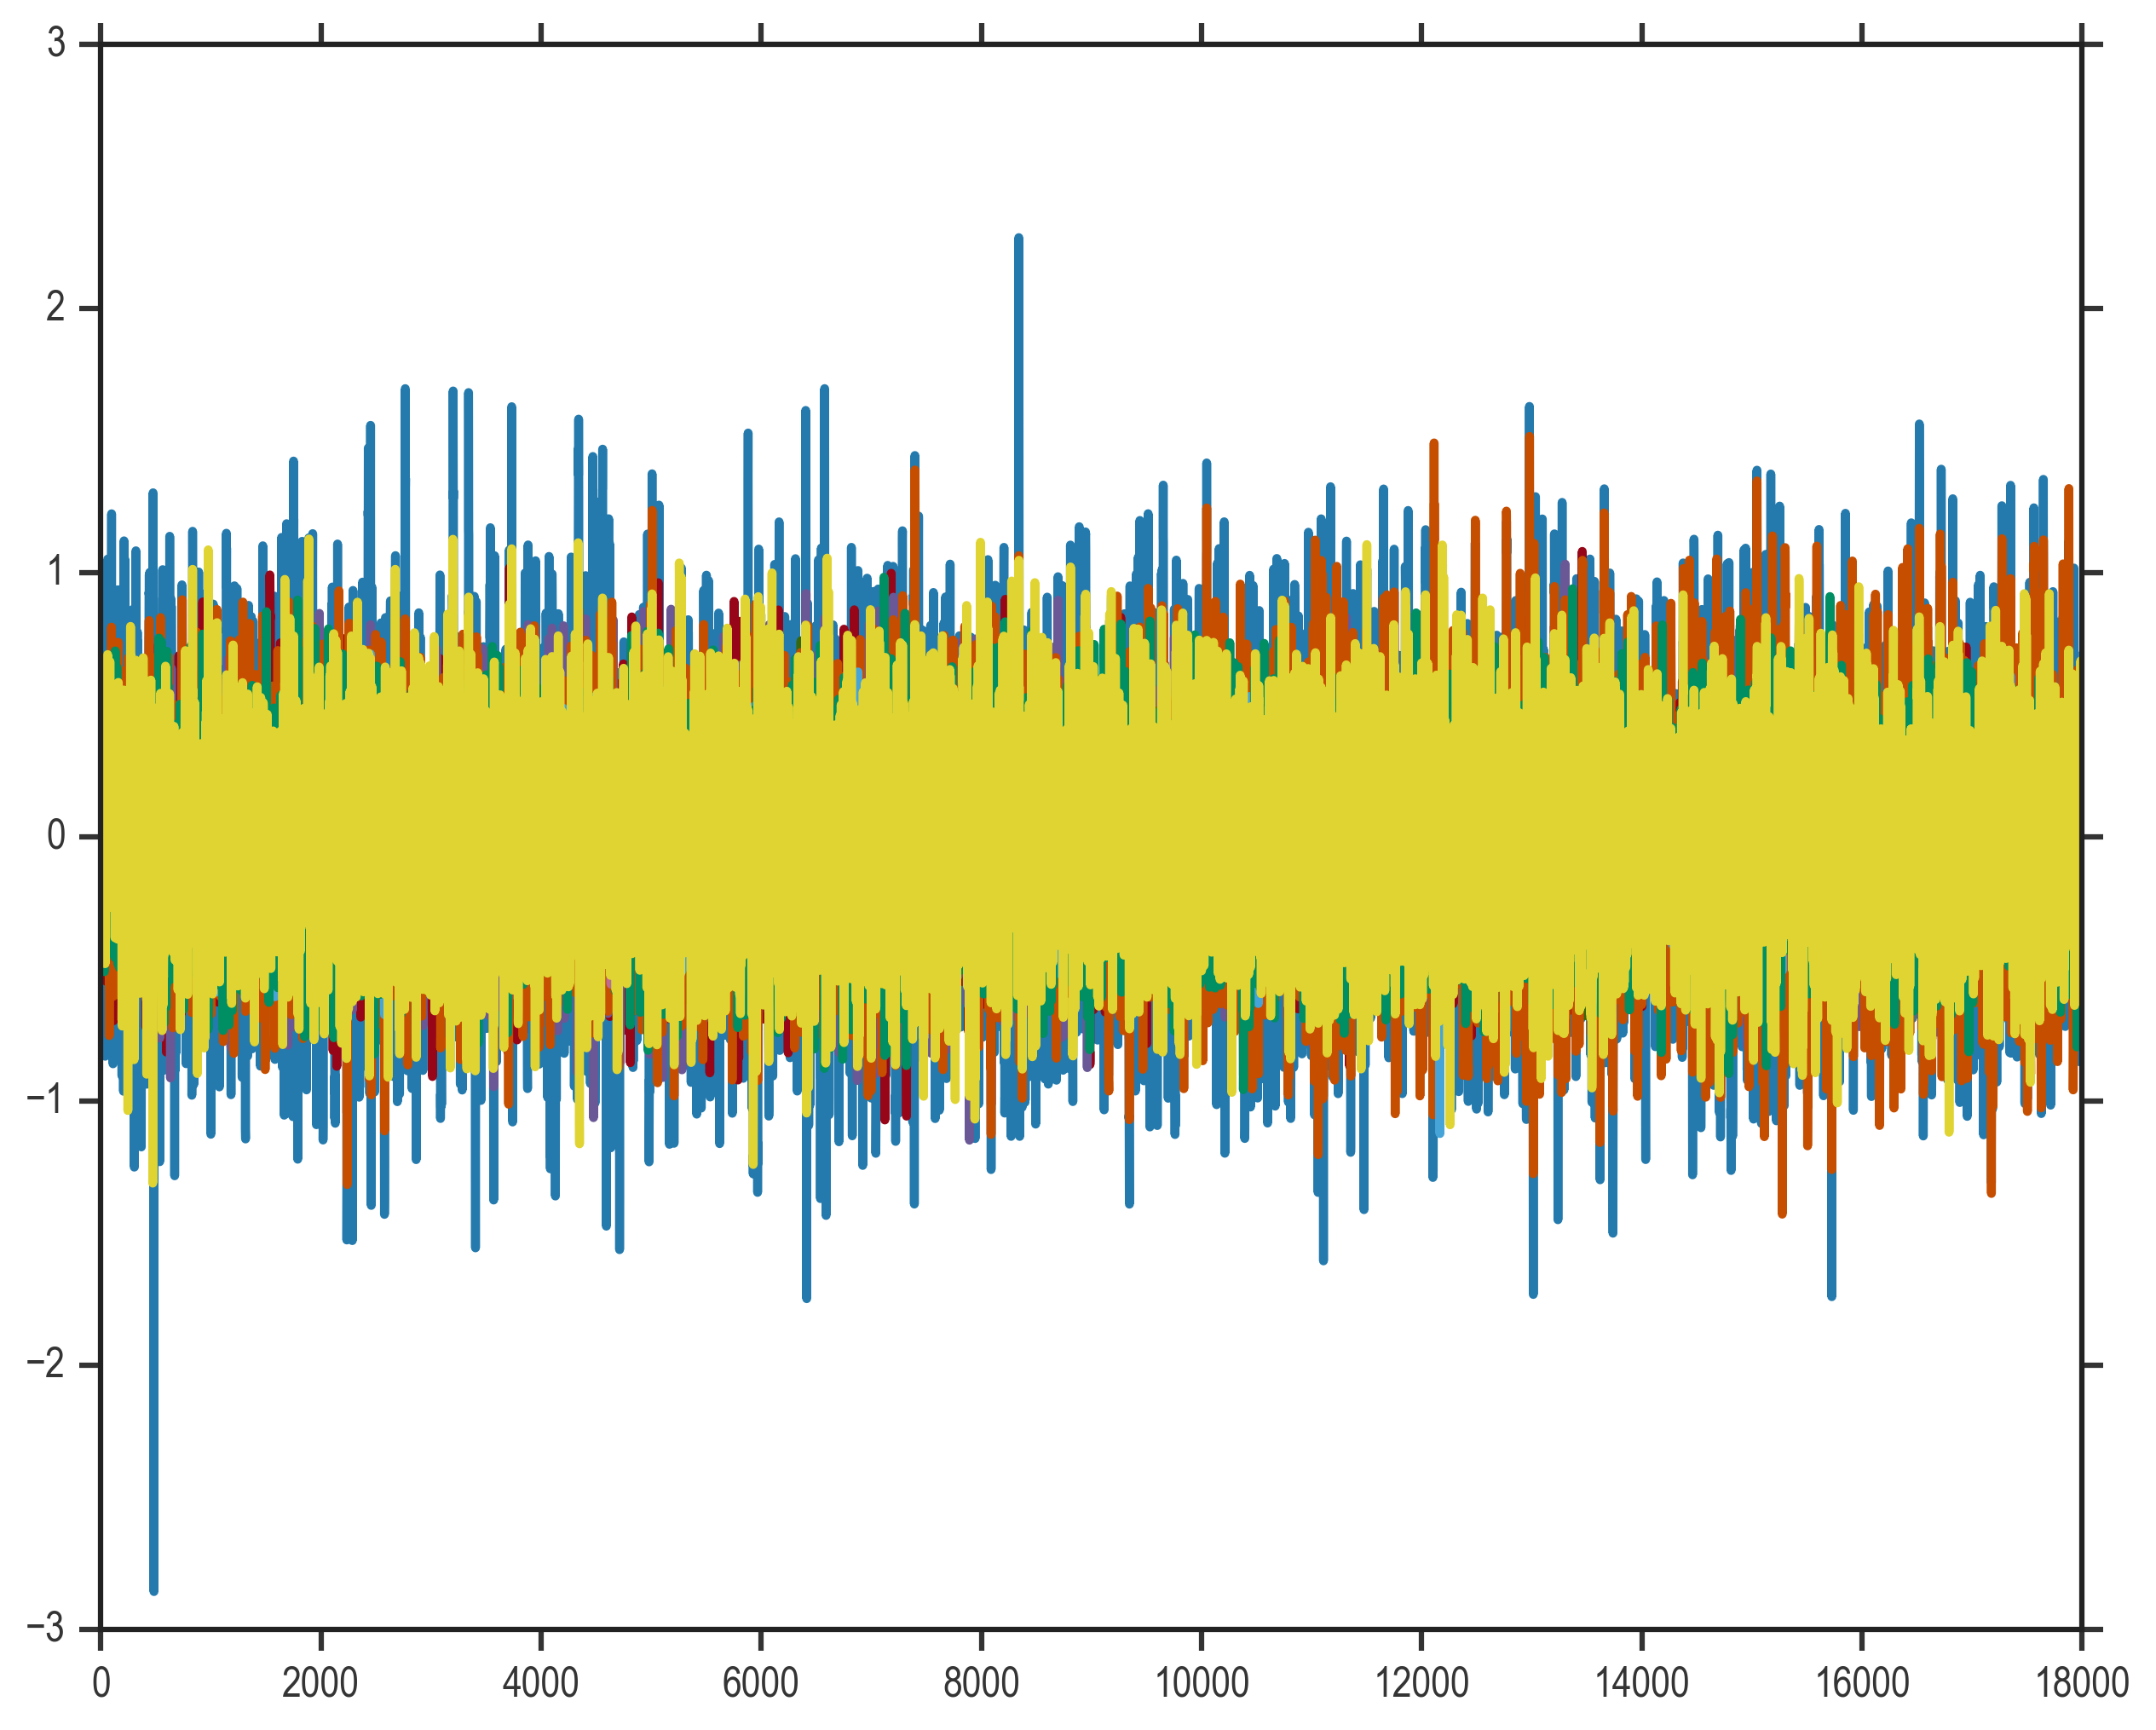

In [140]:
for expt in detrended_membrane_potentials['linesRF_v']:
    plt.plot(detrended_membrane_potentials['linesRF_v'][expt])
# xlim(200,220)

In [145]:
np.stack([detrended_membrane_potentials['linesRF_v'][key] for key in detrended_membrane_potentials['linesRF_v']]).shape

(9, 17989)

## Save h5 file

In [147]:
sorted_expts = sorted([key for key in detrended_membrane_potentials['intraRF_v']])

In [150]:
sorted_expts

['011812_c1',
 '020612_c2',
 '090312_r1_c1',
 '092312_r1_c1',
 '092312_r3_c1',
 '120212_r1_c1',
 '121612_r2_c1',
 '122412_r1_c1',
 '122412_r2_c1']

In [153]:
receptive_fields.keys()

dict_keys(['flash', 'intraRF', 'linesRF'])

In [154]:
stimuli.keys()

dict_keys(['boxes', 'flashStim', 'lines'])

In [155]:
membrane_potentials.keys()

dict_keys(['linesRF_v', 'intraRF_v', 'flash_v'])

In [160]:
[len(s) for s in sorted_expts]

[9, 9, 12, 12, 12, 12, 12, 12, 12]

In [161]:
with h5py.File('horizontals.h5', 'w') as g:
    # expts
    ascii_expts = [n.encode("ascii", "ignore") for n in sorted_expts]
    g.create_dataset('expts', (len(ascii_expts),1), 'S12', ascii_expts)
    
    # stimuli
    g.create_dataset('lines/stimuli', data=stimuli['lines'])
    g.create_dataset('boxes/stimuli', data=stimuli['boxes'])
    g.create_dataset('flashes/stimuli', data=stimuli['flashStim'])
    
    # time
    g.create_dataset('lines/time', data=stimuli_time['lines'])
    g.create_dataset('boxes/time', data=stimuli_time['boxes'])
    g.create_dataset('flashes/time', data=stimuli_time['flashStim'])
    
    # receptive fields
    for expt in sorted_expts:
        g.create_dataset('lines/rfs/%s' %expt, data=receptive_fields['linesRF'][expt])
        g.create_dataset('boxes/rfs/%s' %expt, data=receptive_fields['intraRF'][expt])
        g.create_dataset('flashes/rfs/%s' %expt, data=receptive_fields['flash'][expt])
        
    # membrane potentials
    g.create_dataset('lines/membrane_potential',
                    data=np.stack(membrane_potentials['linesRF_v'][key] for key in sorted_expts))
    g.create_dataset('boxes/membrane_potential',
                data=np.stack(membrane_potentials['intraRF_v'][key] for key in sorted_expts))
    g.create_dataset('flashes/membrane_potential',
                data=np.stack(membrane_potentials['flash_v'][key] for key in sorted_expts))
    
    # detrended membrane potentials
    g.create_dataset('lines/detrended_membrane_potential',
                    data=np.stack(detrended_membrane_potentials['linesRF_v'][key] for key in sorted_expts))
    g.create_dataset('boxes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['intraRF_v'][key] for key in sorted_expts))
    g.create_dataset('flashes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['flash_v'][key] for key in sorted_expts))

# Compare saved experiment to early experiments that don't have good RFs this way

In [162]:
expt = '011812_c1'
early_stimuli = {}
early_stimuli_time = {}

for idh,h_file in enumerate(horizontals):
    h_id = h_file.split('/')[-1]
    if h_id == expt:
        # stimuli
        boxes = np.loadtxt(h_file + '/boxes.txt', skiprows=1)
        lines = np.loadtxt(h_file + '/lines.txt', skiprows=1)
        flashStim = np.loadtxt(h_file + '/flashStim.txt', skiprows=1)
        
        # reshape stimuli
        boxes = boxes.reshape((-1, 38, 38))
        lines = lines.reshape((-1, 100))
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            readme_lines = text.split('\n')
            for l in readme_lines:
                params = l.split(', ')
                if params[0] in ['flashStim', 'boxes', 'lines']:
                    times[params[0]] = np.linspace(float(params[-2]), float(params[-1]), len(eval(params[0])))
                    scaling_factor = np.mean(np.diff(times[params[0]]))/sampling_rate
                    if scaling_factor > 1:
                        print('%s in %s is going to be upsampled by %f' %(params[0], h_id, scaling_factor))
                        stim_us, time_us = st.upsample_stim(eval(params[0]), int(scaling_factor), times[params[0]])
                    else:
                        print('%s in %s is going to be downsampled by %f' %(params[0], h_id, 1./scaling_factor))
                        stim_us, time_us = st.downsample_stim(eval(params[0]), int(1./scaling_factor), times[params[0]])

                    if params[0] in ['flashStim']:
                        idx = np.argmin(abs(minimum_times['flash_v'] - time_us))
                        early_stimuli_time['flashStim'] = time_us[:idx]
                        early_stimuli['flashStim'] = stim_us[:idx]
                    elif params[0] in ['boxes']:
                        idx = np.argmin(abs(minimum_times['intraRF_v'] - time_us))
                        early_stimuli_time['boxes'] = time_us[:idx]
                        early_stimuli['boxes'] = stim_us[:idx]
                    elif params[0] in ['lines']:
                        idx = np.argmin(abs(minimum_times['linesRF_v'] - time_us))
                        early_stimuli_time['lines'] = time_us[:idx]
                        early_stimuli['lines'] = stim_us[:idx]

boxes in 011812_c1 is going to be upsampled by 3.334796
lines in 011812_c1 is going to be upsampled by 3.334978
flashStim in 011812_c1 is going to be downsampled by 99.999545


In [169]:
early_stimuli['lines'].shape

(16192, 100)

In [171]:
stimuli['lines'].shape

(17989, 100)

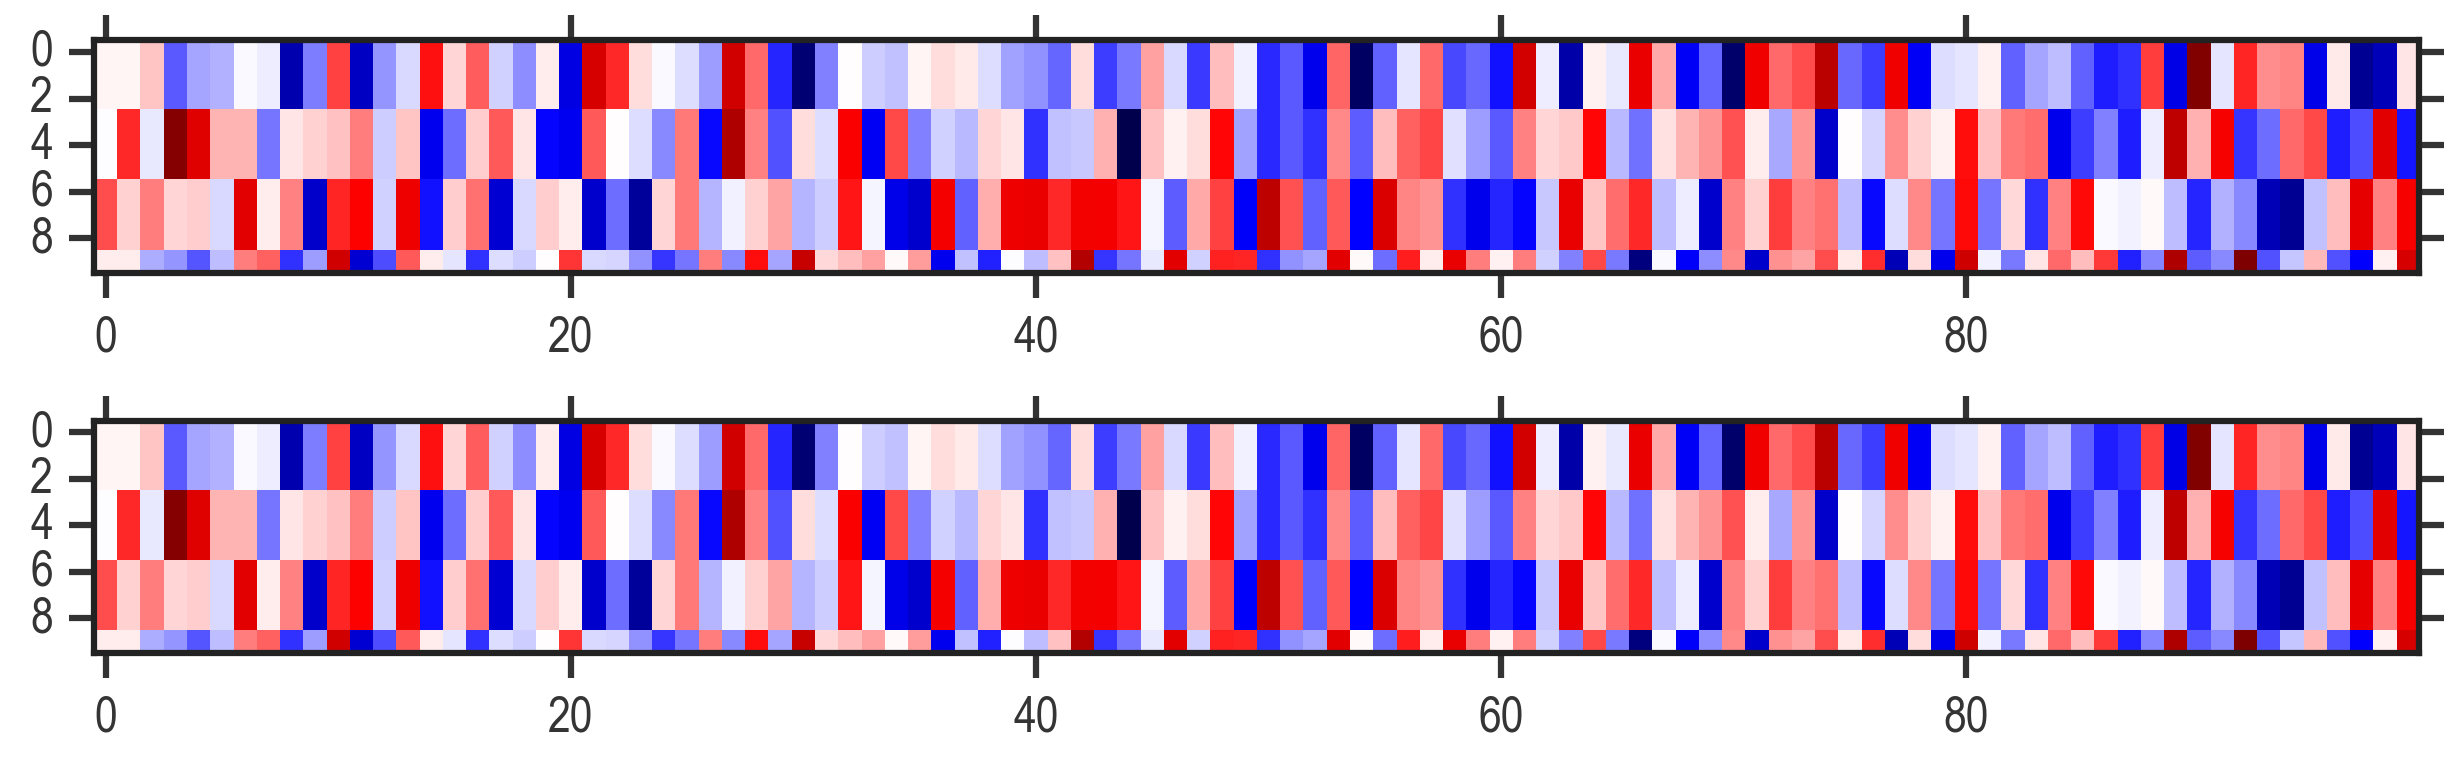

In [173]:
fig = plt.gcf()
fig.set_size_inches((10,3))

plt.subplot(211)
plt.imshow(stimuli['lines'][15000:15010])

plt.subplot(212)
plt.imshow(early_stimuli['lines'][15000:15010])

In [175]:
difference = early_stimuli['lines'] - stimuli['lines'][:len(early_stimuli['lines'])]
difference.shape

(16192, 100)

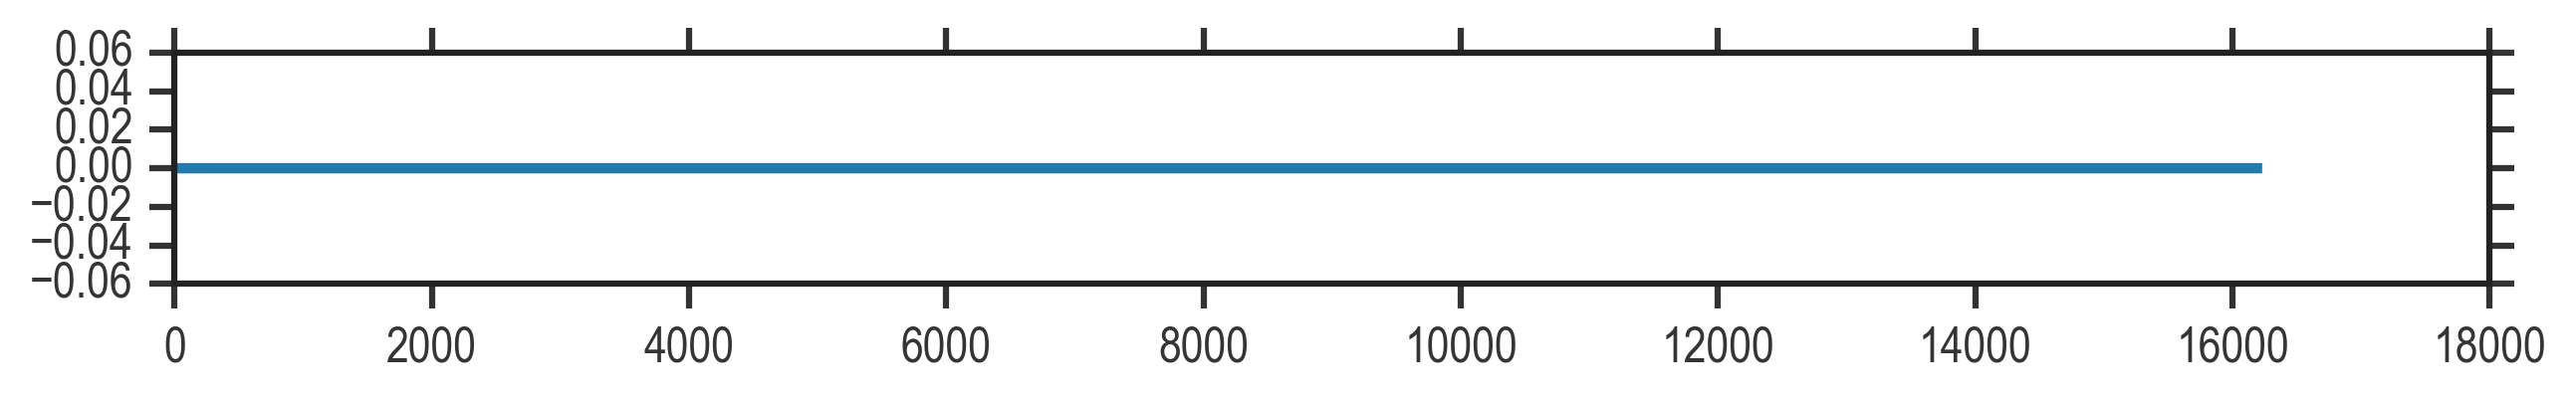

In [180]:
fig = plt.gcf()
fig.set_size_inches((10,1))
plt.plot(np.sum(abs(difference), axis=1))

In [181]:
early_stimuli_time['lines'][-1]

179.98878026008668

In [182]:
stimuli_time['lines'][-1]

179.98618229114558

In [183]:
lines.shape

(8998, 100)

In [185]:
times['lines'][-1]

300.048

## Save two h5 files, one for each stimulus

In [187]:
late_2012_expts = sorted_expts[2:]
with h5py.File('horizontals_late_2012.h5', 'w') as g:
    # expts
    ascii_expts = [n.encode("ascii", "ignore") for n in late_2012_expts]
    g.create_dataset('expts', (len(ascii_expts),1), 'S12', ascii_expts)
    
    # stimuli
    g.create_dataset('lines/stimuli', data=stimuli['lines'])
    g.create_dataset('boxes/stimuli', data=stimuli['boxes'])
    g.create_dataset('flashes/stimuli', data=stimuli['flashStim'])
    
    # time
    g.create_dataset('lines/time', data=stimuli_time['lines'])
    g.create_dataset('boxes/time', data=stimuli_time['boxes'])
    g.create_dataset('flashes/time', data=stimuli_time['flashStim'])
    
    # receptive fields
    for expt in late_2012_expts:
        g.create_dataset('lines/rfs/%s' %expt, data=receptive_fields['linesRF'][expt])
        g.create_dataset('boxes/rfs/%s' %expt, data=receptive_fields['intraRF'][expt])
        g.create_dataset('flashes/rfs/%s' %expt, data=receptive_fields['flash'][expt])
        
    # membrane potentials
    g.create_dataset('lines/membrane_potential',
                    data=np.stack(membrane_potentials['linesRF_v'][key] for key in late_2012_expts))
    g.create_dataset('boxes/membrane_potential',
                data=np.stack(membrane_potentials['intraRF_v'][key] for key in late_2012_expts))
    g.create_dataset('flashes/membrane_potential',
                data=np.stack(membrane_potentials['flash_v'][key] for key in late_2012_expts))
    
    # detrended membrane potentials
    g.create_dataset('lines/detrended_membrane_potential',
                    data=np.stack(detrended_membrane_potentials['linesRF_v'][key] for key in late_2012_expts))
    g.create_dataset('boxes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['intraRF_v'][key] for key in late_2012_expts))
    g.create_dataset('flashes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['flash_v'][key] for key in late_2012_expts))

In [189]:
sorted_expts[:2]

['011812_c1', '020612_c2']

In [190]:
early_2012_expts = sorted_expts[:2]

In [193]:
sampling_rate = 0.01
early_target_times = {}
for key in minimum_times.keys():
    if key == 'intraRF_v':
        early_target_times[key] = early_stimuli_time['boxes']
    elif key == 'linesRF_v':
        early_target_times[key] = early_stimuli_time['lines']
    elif key == 'flash_v':
        early_target_times[key] = early_stimuli_time['flashStim']
        
smoothing_step = int(2/.001) # 2 second smoothing filter

for idh,h_file in tqdm(enumerate(horizontals)):
    h_id = h_file.split('/')[-1]
    if h_id in early_2012_expts:
        
        # membrane potential
        intraRF_v = np.loadtxt(h_file + '/intraRF_v.txt', skiprows=1)
        linesRF_v = np.loadtxt(h_file + '/linesRF_v.txt', skiprows=1)
        flash_v = np.loadtxt(h_file + '/flash_v.txt', skiprows=1)
        
        # read README to get times
        times = collections.defaultdict(list)
        with open(h_file + '/README.txt', 'r') as f:
            text = f.read()
            lines = text.split('\n')
            for l in lines:
                params = l.split(', ')
                if params[0] in ['flash', 'flash_v', 'intraRF', 'intraRF_v', 'linesRF_v']:
                    times[params[0]] = np.linspace(float(params[1]), float(params[2]), len(eval(params[0])))
        
        # interpolate membrane potentials
        for key in ['flash_v', 'intraRF_v', 'linesRF_v']:
            mem_pot_interp = interp1d(times[key], eval(key), kind='linear', bounds_error=False,
                                     fill_value='extrapolate')
            membrane_potentials[key][h_id] = mem_pot_interp(early_target_times[key])
            
            # detrend
            detrended_mem_pot = detrend(eval(key), type='linear', bp=np.arange(smoothing_step, 
                                                                               len(eval(key))-smoothing_step,
                                                                               smoothing_step))
            
            detrended_interp = interp1d(times[key], detrended_mem_pot, kind='linear', bounds_error=False,
                                       fill_value='extrapolate')
            detrended_membrane_potentials[key][h_id] = detrended_interp(early_target_times[key])


In [195]:
early_target_times['linesRF_v'].shape

(16192,)

In [196]:
early_2012_expts

['011812_c1', '020612_c2']

In [203]:
detrended_membrane_potentials['linesRF_v'][early_2012_expts[0]].shape

(16192,)

In [204]:
early_2012_expts = sorted_expts[:2]
with h5py.File('horizontals_early_2012.h5', 'w') as g:
    # expts
    ascii_expts = [n.encode("ascii", "ignore") for n in early_2012_expts]
    g.create_dataset('expts', (len(ascii_expts),1), 'S12', ascii_expts)
    
    # stimuli
    g.create_dataset('lines/stimuli', data=early_stimuli['lines'])
    g.create_dataset('boxes/stimuli', data=early_stimuli['boxes'])
    g.create_dataset('flashes/stimuli', data=early_stimuli['flashStim'])
    
    # time
    g.create_dataset('lines/time', data=early_stimuli_time['lines'])
    g.create_dataset('boxes/time', data=early_stimuli_time['boxes'])
    g.create_dataset('flashes/time', data=early_stimuli_time['flashStim'])
    
    # receptive fields
    for expt in early_2012_expts:
        g.create_dataset('lines/rfs/%s' %expt, data=receptive_fields['linesRF'][expt])
        g.create_dataset('boxes/rfs/%s' %expt, data=receptive_fields['intraRF'][expt])
        g.create_dataset('flashes/rfs/%s' %expt, data=receptive_fields['flash'][expt])
        
    # membrane potentials
    g.create_dataset('lines/membrane_potential',
                    data=np.stack(membrane_potentials['linesRF_v'][key] for key in early_2012_expts))
    g.create_dataset('boxes/membrane_potential',
                data=np.stack(membrane_potentials['intraRF_v'][key] for key in early_2012_expts))
    g.create_dataset('flashes/membrane_potential',
                data=np.stack(membrane_potentials['flash_v'][key] for key in early_2012_expts))
    
    # detrended membrane potentials
    g.create_dataset('lines/detrended_membrane_potential',
                    data=np.stack(detrended_membrane_potentials['linesRF_v'][key] for key in early_2012_expts))
    g.create_dataset('boxes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['intraRF_v'][key] for key in early_2012_expts))
    g.create_dataset('flashes/detrended_membrane_potential',
                data=np.stack(detrended_membrane_potentials['flash_v'][key] for key in early_2012_expts))